1. PDBファイルの準備
2. docking
3. 既知リガンドとの比較
- ChEMBLから既知リガンドを取得
- 既知リガンドの活性値とdocking scoreの相関確認
4. docking scoreと活性値の予測
- 既知リガンドモデル作成
- 予測

directory setup

In [3]:
import os
import glob

cwd = os.getcwd()
user = 'keetane'
project = 'ruxolitinib'
wd = os.path.join(cwd, '1_wd', user, project)
input_dir    = os.path.join(wd, 'input');    os.makedirs(input_dir, exist_ok=True)
results_dir  = os.path.join(wd, 'results');  os.makedirs(results_dir, exist_ok=True)
results_log  = os.path.join(results_dir, 'log');  os.makedirs(results_log, exist_ok=True)
toml_dir     = os.path.join(wd, 'toml');     os.makedirs(toml_dir, exist_ok=True)
toml_path = os.path.join(toml_dir, "sampling.toml")
sampling_log = os.path.join(results_dir, 'log'); os.makedirs(sampling_log, exist_ok=True)
input_dir

'/Users/keetane/Documents/apps/REINVENT4/1_wd/keetane/ruxolitinib/input'

## 1. PDBファイルの準備

JAK2 JH1とJH2のPDBファイルをダウンロード。  
JH1は8BXH, JH2は8BA3

In [ ]:
import os
import requests

pdb_ids = ['8BXH', '8BA3']
base_url = "https://files.rcsb.org/download/"

for pdb_id in pdb_ids:
    url = f"{base_url}{pdb_id}.pdb"
    output_filepath = os.path.join(input_dir, f"{pdb_id}.pdb")

    try:
        response = requests.get(url)
        response.raise_for_status() # HTTPエラーを確認

        with open(output_filepath, 'wb') as f:
            f.write(response.content)
    except requests.exceptions.RequestException as e:
        print(f"Error downloading {pdb_id}.pdb: {e}")

pymolでpdbを重ね合わせて保存

In [ ]:
import os
import pymol

pdb_file_1 = os.path.join(input_dir, f'{pdb_ids[0]}.pdb')
pdb_file_2 = os.path.join(input_dir, f'{pdb_ids[1]}.pdb')

# PyMOLを起動し、バックグラウンドで実行
pymol.cmd.reinitialize()

# オリジナルPDBファイルを読み込む
pymol.cmd.load(pdb_file_1, f'{pdb_ids[0]}')
pymol.cmd.load(pdb_file_2, f'{pdb_ids[1]}')

# 8BA3を8BXHにchain Aで重ね合わせる
pymol.cmd.align(f'{pdb_ids[1]} and chain A', f'{pdb_ids[0]} and chain A')

# 重ね合わせた結果を元のファイルパスに上書き保存
pymol.cmd.save(pdb_file_2, f'{pdb_ids[1]}')

重ね合わせた結果を確認

In [ ]:
import os
import py3Dmol

pdb_file_1 = os.path.join(input_dir, f'{pdb_ids[0]}.pdb')
pdb_file_2 = os.path.join(input_dir, f'{pdb_ids[1]}.pdb')

# 3Dビューアを作成
view = py3Dmol.view(width=800, height=600)

# 8BXH (参照構造) を読み込み、異なる色で表示
with open(pdb_file_1, 'r') as f:
    pdb_data_1 = f.read()
view.addModel(pdb_data_1, 'pdb')
view.setStyle({'model':0}, {'cartoon': {'color': 'blue'}}) # 1番目のモデルを青で表示

# 重ね合わせた8BA3 (移動構造) を読み込み、異なる色で表示
with open(pdb_file_2, 'r') as f:
    pdb_data_2 = f.read()
view.addModel(pdb_data_2, 'pdb')
view.setStyle({'model':1}, {'cartoon': {'color': 'red'}}) # 2番目のモデルを赤で表示

# タンパク質の中心に視点を合わせる
view.zoomTo()

# ビューアを表示
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

receptorとligandを抽出。

In [ ]:
# PyMOLを起動し、バックグラウンドで実行
pymol.cmd.reinitialize()

for pdb_id in pdb_ids:
    pdb_path = os.path.join(input_dir, f'{pdb_id}.pdb')
    pymol.cmd.load(pdb_path, pdb_id)
    rec_path = os.path.join(input_dir, f'rec_{pdb_id}.pdb')
    pymol.cmd.save(rec_path, f'{pdb_id} and polymer.protein')
    lig_path = os.path.join(input_dir, f'lig_{pdb_id}.pdb')
    pymol.cmd.save(lig_path, f'{pdb_id} and organic')

## 2. docking


sminaのパス確認

In [14]:
!which smina

/usr/local/bin/smina


### smina関数の作成

In [ ]:
import subprocess as sp

def smina(receptor, ligand, box, output, puff=4 , num_modes=3, exhaustiveness=8, seed=0, log_file=None):
    cmd = ['smina',
        '--receptor', receptor,
        '--ligand', ligand,
        '--autobox_ligand', box,
        '--autobox_add', str(puff),
        '--out', output,
        '--num_modes', str(num_modes),
        '--exhaustiveness', str(exhaustiveness),
        '--seed', str(seed),
        '--log', log_file if log_file else '/dev/null'
        ]
    sp.run(cmd, check=True, stdout=sp.PIPE, stderr=sp.PIPE)

### redockでsmina関数のテスト

In [16]:
pdb_ids = ['8BXH', '8BA3']
smina(receptor=os.path.join(input_dir, f'rec_{pdb_ids[0]}.pdb'),
      ligand=os.path.join(input_dir, f'lig_{pdb_ids[0]}.pdb'),
      box=os.path.join(input_dir, f'rec_{pdb_ids[0]}.pdb'),
      output=os.path.join(results_dir, f'redocked_{pdb_ids[0]}.sdf'),
)

redockの結果を確認

In [ ]:
import os
import py3Dmol

# 表示するファイルのパス
pdb_file_8bxh = os.path.join(input_dir, '8BXH.pdb')
docked_ligand_sdf = os.path.join(results_dir, 'redocked_8BXH.sdf')

# 3Dビューア作成
view = py3Dmol.view(width=800, height=600)

model_index = 0

# --- 1. レセプター読み込み（model 0） ---
if os.path.exists(pdb_file_8bxh):
    with open(pdb_file_8bxh, 'r') as f:
        pdb_data = f.read()
    view.addModel(pdb_data, 'pdb')  # model 0
    print(f"Loaded receptor: {pdb_file_8bxh}")
    model_index += 1
else:
    print(f"Error: Receptor file not found at {pdb_file_8bxh}")

# --- 2. リガンド（SDF）読み込み（model 1 以降） ---
ligand_model_count = 0
if os.path.exists(docked_ligand_sdf):
    with open(docked_ligand_sdf, 'r') as f:
        sdf_data = f.read()
    view.addModels(sdf_data, 'sdf')
    ligand_model_start = model_index
    ligand_model_count = sdf_data.count('$$$$')
    print(f"Loaded docked ligands: {ligand_model_count}")
else:
    print(f"Error: Docked ligand file not found at {docked_ligand_sdf}")
    ligand_model_start = None

# --- 3. スタイル設定 ---
# 全体にスティック表示（初期スタイル）
view.setStyle({}, {'stick': {}})

# モデル0（レセプター）を青カートゥーンで表示
view.setStyle({'model': 0}, {'cartoon': {'color': 'blue'}})

# モデル0のHETATM（例：元のリガンド）全体をlineで表示
view.setStyle({'model': 0, 'hetflag': True}, {'line': {}})

# モデル0のHETATM中の炭素原子（C）だけを黒色で上書き
view.setStyle({'model': 0, 'hetflag': True, 'elem': 'C'}, {'line': {'color': 'black'}})

# redocked_8BXH（SDFリガンド）にスタイルを適用
if ligand_model_start is not None:
    for i in range(ligand_model_start, ligand_model_start + ligand_model_count):
        view.setStyle({'model': i, 'elem': 'C'}, {'stick': {'color': 'orange'}})
        view.setStyle({'model': i, 'not': {'elem': 'C'}}, {'stick': {}})



# --- 4. 表示処理 ---
view.zoomTo({'model': 1})  # redock_8BXHのリガンドにズーム
view.show()


Loaded receptor: /Users/keetane/Documents/apps/REINVENT4/1_wd/keetane/ruxolitinib/input/8BXH.pdb
Loaded docked ligands: 3


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

.csvファイルから化合物を一つずつ取り出して三次元化とdocking

PubChemからSMILESを呼び出す関数

In [19]:
import pubchempy as pcp
import requests
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import Image, display

# SMILESを取得するシンプルな関数
def get_simple_smiles(query, query_type='name'):
    # PubChemPyでCIDを取得
    compound = pcp.get_compounds(query, query_type)[0]
    cid = compound.cid

    # PubChem Pug REST APIを直接呼び出し
    api_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/JSON"
    response = requests.get(api_url)
    data = response.json()
    
    # 応答からSMILESを抽出
    compound_data = data['PC_Compounds'][0]
    smiles_options = {
        'Isomeric': None,
        'Absolute': None,
        'Canonical': None,
        'Connectivity': None
    }

    for prop in compound_data['props']:
        if prop['urn']['label'] == 'SMILES':
            smiles_name = prop['urn']['name']
            if smiles_name in smiles_options:
                smiles_options[smiles_name] = prop['value']['sval']
    
    # 優先順位: Isomeric -> Absolute -> Canonical -> Connectivity
    if smiles_options['Isomeric']:
        return smiles_options['Isomeric']
    elif smiles_options['Absolute']:
        return smiles_options['Absolute']
    elif smiles_options['Canonical']:
        return smiles_options['Canonical']
    else: # Connectivity
        return smiles_options['Connectivity']


ruxolitinibのSMILESを取得

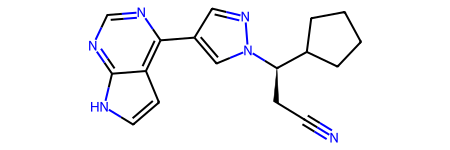

In [20]:
mol_name = 'Ruxolitinib'  # ここに分子名を入力
mol_smiles = get_simple_smiles(mol_name, 'name')
# RDKitで分子オブジェクトを作成し、描画
Chem.MolFromSmiles(mol_smiles)

三次元化関数

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from gypsum_dl import GypsumDL

# rdkitで三次元化
def smiles_mol(smiles):
    mol = Chem.MolFromSmiles(smiles)
    # molに水素を追加
    mol = Chem.AddHs(mol)
    # molを三次元化
    AllChem.EmbedMolecule(mol, randomSeed=42)
    AllChem.UFFOptimizeMolecule(mol)
    # 一時ファイルを作成してSDF形式で保存
    temp_sdf_path = os.path.join(input_dir, 'temp.sdf')
    writer = Chem.SDWriter(temp_sdf_path)
    writer.write(mol)
    writer.close()

# gypsum-dlで三次元化した分子をSDF形式で保存する関数
def gypsum(smiles, n_mols=2):
    smiles_list = [mol for mol in GypsumDL(smiles,max_variants_per_compound=n_mols)]
    sdf_list = [Chem.MolFromSmiles(i) for i in smiles_list]
    with Chem.SDWriter(f'{input_dir}/temp.sdf') as writer:
        for mol in sdf_list:
            writer.write(mol)

# gypsum CLIで分子を三次元化
def gypsum_cli(smiles, isomers=3, ph_min=6.8, ph_max=7.4):
    smiles_path = os.path.join(input_dir, 'temp.smi')
    with open(smiles_path, 'w') as f:
        f.write(smiles + '\n')
    cmd = ['run-gypsum-dl',
           '--source', smiles_path,
           '-o', f'{input_dir}',
           '--max_variants_per_compound', str(isomers),
           '--min_ph_ MIN', str(ph_min),
           '--max_ph_ MAX', str(ph_max),
           ]
    sp.run(cmd, check=True, stdout=sp.PIPE, stderr=sp.PIPE)

三次元化関数のテスト

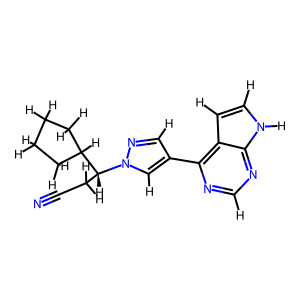

In [22]:
smiles_mol(mol_smiles, draw=True)


### samplingした構造をdocking

## 3. 既知リガンドとの比較
### ChEMBLから既知リガンドを取得


In [9]:
# Import necessary libraries
from chembl_webresource_client.new_client import new_client
import requests
import pandas as pd
from rdkit.Chem import AllChem, PandasTools, rdRGroupDecomposition, Descriptors, Draw, Descriptors3D, rdMolDescriptors
from rdkit import DataStructs, rdBase, Chem

import platform
# print('python version: ' + platform.python_version())
# print(f'rdkit version: {rdBase.rdkitVersion}')

UniProt IDからTarget ChEMBL IDを検索  
https://www.uniprot.org/uniprotkb?query=JAK2

In [10]:
uniprot_id = 'O60674'  # JAK2のUniProt ID
target = new_client.target.get(
    target_components__accession=uniprot_id
    ).only(
        'target_chembl_id', 
        'organism', 
        'pref_name', 
        'target_type'
        )
df = pd.DataFrame.from_records(target)
df

,organism,pref_name,target_chembl_id,target_type
0,Homo sapiens,Tyrosine-protein kinase JAK2,CHEMBL2971,SINGLE PROTEIN
1,Homo sapiens,Tyrosine-protein kinase JAK2,CHEMBL2971,SINGLE PROTEIN
2,Homo sapiens,Janus Kinase (JAK),CHEMBL2363062,PROTEIN FAMILY
3,Homo sapiens,JAK2/JAK1,CHEMBL3038492,PROTEIN COMPLEX
4,Homo sapiens,JAK1/JAK2/TYK2,CHEMBL3301390,PROTEIN COMPLEX
5,Homo sapiens,JAK2/TYK2,CHEMBL3301392,PROTEIN COMPLEX
6,Homo sapiens,E3 ubiquitin-protein ligase XIAP/JAK2,CHEMBL4630750,PROTEIN-PROTEIN INTERACTION
7,Homo sapiens,Cereblon/Tyrosine-protein kinase JAK2,CHEMBL4742263,PROTEIN-PROTEIN INTERACTION
8,Homo sapiens,JAK2/JAK3,CHEMBL4802035,PROTEIN FAMILY
9,Homo sapiens,JAK2-STAT3,CHEMBL5482983,PROTEIN COMPLEX


ChEMBL IDからデータを取得する

In [11]:
ChEMBL_id = df['target_chembl_id'].values[0]
activities = new_client.activity.filter(
    target_chembl_id__in=ChEMBL_id,  ##Specify a list of example targets
    pchembl_value__gte=5,  ##Specify a minimum threshold of the pChEMBL activity value. Note that pCHEMBL = -log10(IC50, XC50, AC50, Ki, Kd, potency). Greater than or equal to 5 (10um) is a typical minimum rule of thumb for binding activity between a compound and a protein target. 
    assay_type='B',  ##Only look for Binding Assays
).only([
    'molecule_chembl_id',
    'molecule_pref_name',
    # 'target_chembl_id',
    'target_pref_name',
    'parent_molecule_chembl_id',
    'pchembl_value',
    'canonical_smiles',
    # 'assay_description',
    'document_chembl_id',
    'document_journal',
    # 'document_year',
])
df = pd.DataFrame.from_records(activities)


csvを保存

In [12]:
df.to_csv(f'{input_dir}/chembl_api.csv', index=False, header=True, sep=',', encoding='utf-8')


csvを読み込み

In [13]:
df = pd.read_csv(os.path.join(input_dir, 'chembl_api.csv'), sep=',', encoding='utf-8')

### 既知リガンドの活性値とdocking scoreの相関確認


sminaを実行

In [23]:
# docking結果のdirectory作成
docked_dir = os.path.join(results_dir, f'{pdb_ids[0]}_chemble_docked')
os.makedirs(docked_dir, exist_ok=True)
# docking
for index, row in df.iterrows():
    smiles = row['canonical_smiles']
    smiles_mol(smiles, draw=False)  # 分子を三次元化
    smina(receptor=os.path.join(input_dir, f'rec_{pdb_ids[0]}.pdb'),
          ligand=os.path.join(input_dir, 'temp.sdf'),
          box=os.path.join(input_dir, f'lig_{pdb_ids[0]}.pdb'),
          output=os.path.join(docked_dir, f'{index}_docked_{pdb_ids[0]}.sdf')
          )
    print (f"{index}/{len(df)} docking done", end='\r', flush=True)
print(f"\nDocking completed for {pdb_ids[0]} with {len(df)} molecules.")

CalledProcessError: Command '['smina', '--receptor', '/Users/keetane/Documents/apps/REINVENT4/1_wd/keetane/ruxolitinib/input/rec_8BXH.pdb', '--ligand', '/Users/keetane/Documents/apps/REINVENT4/1_wd/keetane/ruxolitinib/input/temp.sdf', '--autobox_ligand', '/Users/keetane/Documents/apps/REINVENT4/1_wd/keetane/ruxolitinib/input/lig_8BXH.pdb', '--autobox_add', '4', '--out', '/Users/keetane/Documents/apps/REINVENT4/1_wd/keetane/ruxolitinib/results/8BXH_chemble_docked/5_docked_8BXH.sdf', '--num_modes', '3', '--exhaustiveness', '8', '--seed', '0', '--log', '/dev/null']' died with <Signals.SIGINT: 2>.

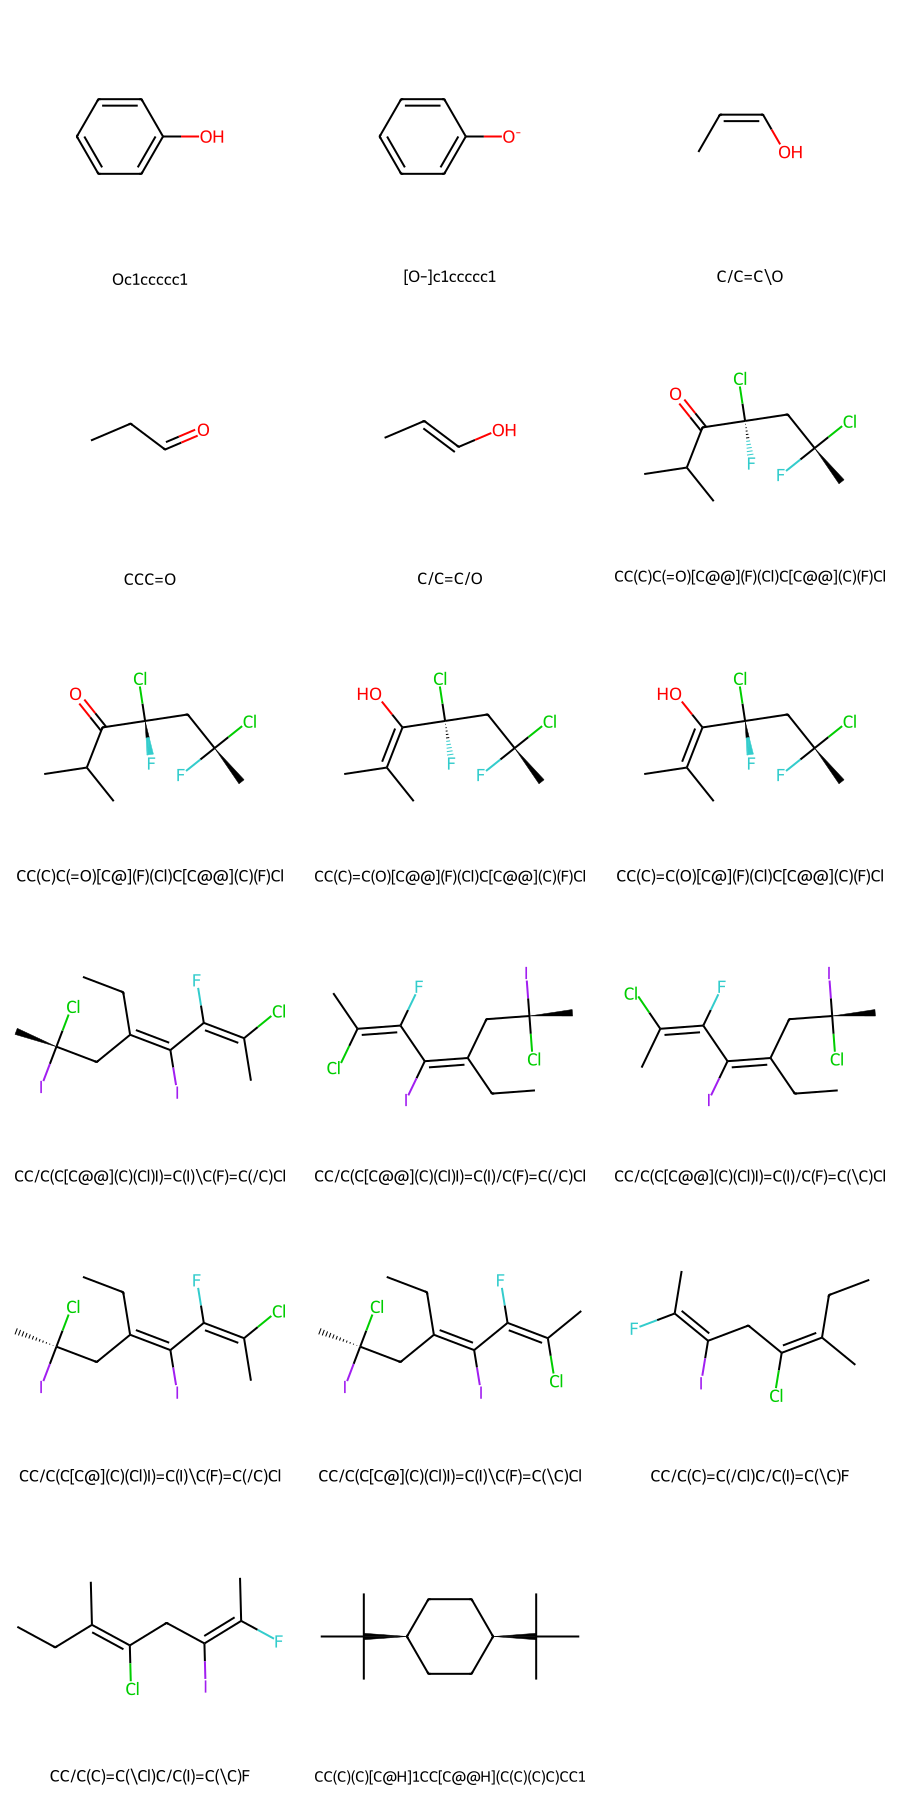

In [34]:
from gypsum_dl import GypsumDL

gypsumed = []

for smiles in [
    'Oc1ccccc1',
    'CCC=O',
    'ClC(C[C@@](Cl)(C)F)(F)C(C(C)C)=O',
    'FC(C(I)=C(CC(I)(Cl)C)CC)=C(Cl)C',
    'CC(CC)=C(C/C(I)=C(C)/F)Cl',
    'CC([C@@H]1CC[C@H](C(C)(C)C)CC1)(C)C',
    ]:

    # print(f"example {smiles}")
    st = GypsumDL(smiles, 
                  min_ph=6.4, 
                  max_ph=8.4, 
                  pka_precision=1.0,
                  thoroughness=3,
                  max_variants_per_compound=5,
                  second_embed=False,
                  skip_optimize_geometry=False,
                  skip_alternate_ring_conformations=False,
                  skip_adding_hydrogen=False,
                  skip_making_tautomers=False,
                  skip_enumerate_chiral_mol=False,
                  skip_enumerate_double_bonds=False,
                  let_tautomers_change_chirality=False,
                  use_durrant_lab_filters=True,
                  job_manager='serial',
                  num_processors=1,
                 )
    for i, smiles in enumerate(st, start=1):
        gypsumed.append(smiles)
        # Draw.MolToImage(Chem.MolFromSmiles(smiles), size=(300, 300))
df = pd.DataFrame(gypsumed, columns=['SMILES'])
df['mol'] = df['SMILES'].apply(lambda x : Chem.MolFromSmiles(x))
Draw.MolsToGridImage(df['mol'], molsPerRow=3, subImgSize=(300, 300), legends=df['SMILES'].values.tolist())

## 4. docking scoreと活性値の予測
### - 既知リガンドモデル作成
### - 予測